En este proyecto vamos a realizar un EDA para seleccionar y preparar los datos útiles para hacer una predicción sobre el precio de las viviendas o habitaciones en AirBnB. Vamos a eliminar datos faltantes cuando sean muy pocos y su eliminación no afecte al rendimiento del modelo.
Vamos a transformar algunas variables que contienen información útil pero no van en un formato adecuado:
+ Para la última fecha de review vamos a aplciar una transformación tal que dispongamos de los días transcurridos desde la última review.
+ La columna que contiene descripciones de los inmuebles puede ser útil, pero debemos trabajar adecuadamente con ella. Para ello vamos a buscar las cadenas de palabras más repetidas y crear columnas categóricas con ellas, que se transformarán con OneHotEncoding.
+ Los barrios y zonas serán transformados en categorías aplicando OneHotEncoding.

Por último, se entrenarán algunos modelos y se sacarán sus estadísticas para evaluar el proceso. No se realizará un análisis completo sobre los modelos y su rendimiento, ya que el objetivo del ejercicio es la preparación de datos.

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import re
from sklearn.model_selection import cross_val_score

In [3]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
df = pd.read_csv(url)

# Rutas subiendo un nivel desde 'src' y luego bajando a 'data/raw', 'interim' y 'process', respectivamente.
directory_raw = os.path.join("..", "data", "raw")
directory_inter = os.path.join("..", "data", "interim")
directory_pro = os.path.join("..", "data", "processed")

# Rutas completas del archivo dentro de 'data/raw', 'interim' y 'process', relativa a la ubicación del script en 'src'
file_path = os.path.join(directory_raw, "AirB_RAW.csv")
file_path2 = os.path.join(directory_inter, "AirB_interim.csv")
file_path3 = os.path.join(directory_pro, "AirB_process.csv")

# Guarda el DataFrame en un archivo CSV
df.to_csv(file_path, index=False)

df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [4]:
df_inter = pd.read_csv(file_path).iloc[:,1:]

pd.set_option('display.max_columns', None)

# Guarda el DataFrame en un archivo CSV
#df_inter.to_csv(file_path2, index = False)
df_inter.shape

(48895, 15)

In [5]:
df_inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month               

In [6]:
df_inter.nunique()

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [7]:
# Consideramos la columna 'Host_Name' como No-útil, porque se solapa con Host_ID, la cual es más precisa. 
df_inter.drop(['host_name'], axis=1, inplace= True)

# En la columna 'Name' encontramos breves descripciones del inmueble o habitación, lo que podemos usar para buscar palabras claves.

df_inter.shape

(48895, 14)

In [8]:
df_inter.duplicated().sum()

0

In [9]:
df_inter.describe().T

,count,mean,std,min,25%,50%,75%,max
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


In [10]:
df_inter.info

<bound method DataFrame.info of                                                     name   host_id  \
0                     Clean & quiet apt home by the park      2787   
1                                  Skylit Midtown Castle      2845   
2                    THE VILLAGE OF HARLEM....NEW YORK !      4632   
3                        Cozy Entire Floor of Brownstone      4869   
4       Entire Apt: Spacious Studio/Loft by central park      7192   
...                                                  ...       ...   
48890    Charming one bedroom - newly renovated rowhouse   8232441   
48891      Affordable room in Bushwick/East Williamsburg   6570630   
48892            Sunny Studio at Historical Neighborhood  23492952   
48893               43rd St. Time Square-cozy single bed  30985759   
48894  Trendy duplex in the very heart of Hell's Kitchen  68119814   

      neighbourhood_group       neighbourhood  latitude  longitude  \
0                Brooklyn          Kensington  40.64749  

In [11]:
# Comprobamos cuántas entradas tienen un valor de 0
np.where(df_inter['price']==0)

(array([23161, 25433, 25634, 25753, 25778, 25794, 25795, 25796, 26259,
        26841, 26866]),)

In [12]:
# Como son pocos los casos con valor 0, podemos eliminar esas filas para mejorar el análisis sin coste estadístico
df_inter = df_inter[df_inter['price'] > 0].copy()

# Guarda el DataFrame en un archivo CSV
df_inter.to_csv(file_path2, index = False)

df_inter.shape

(48884, 14)

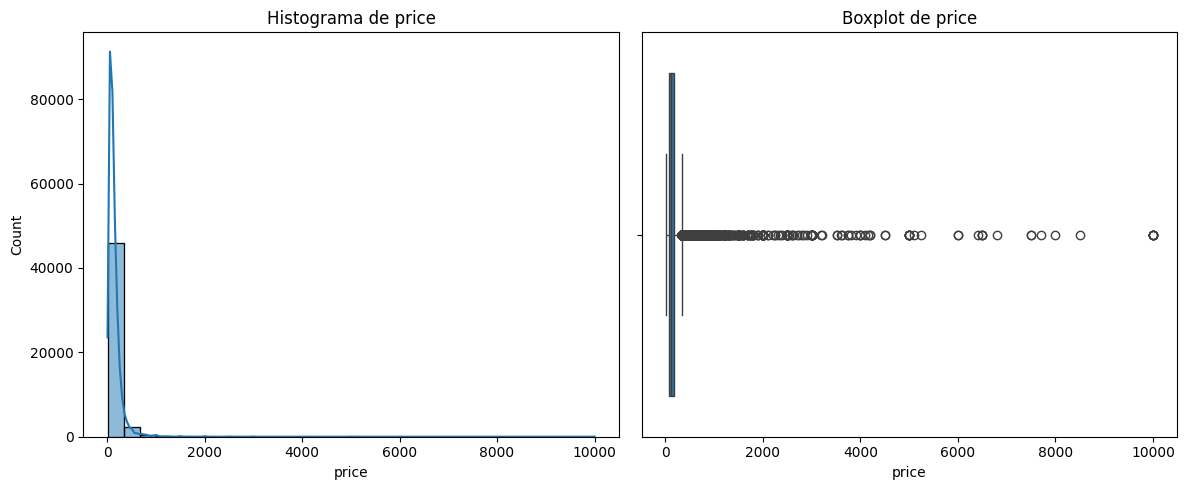

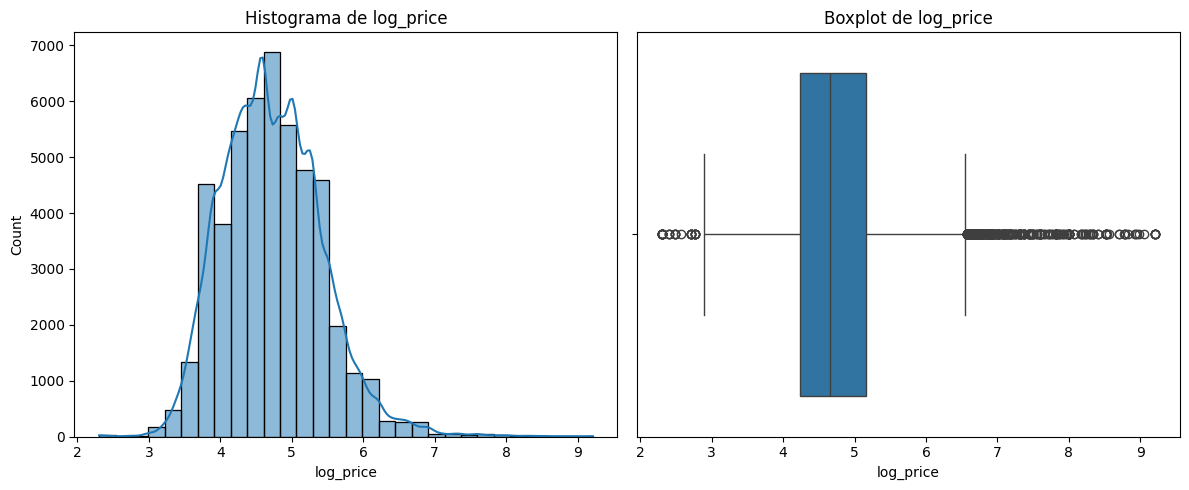

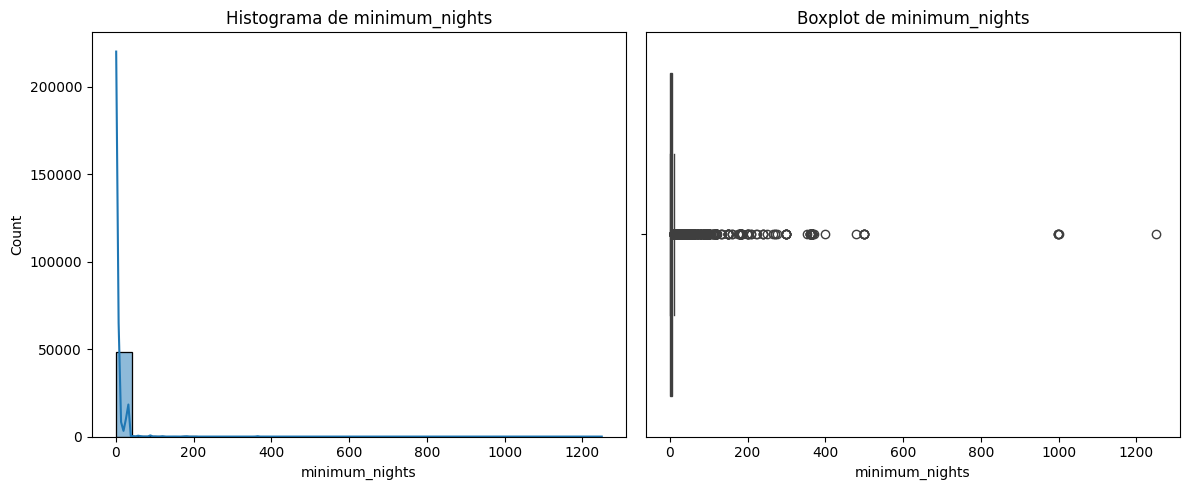

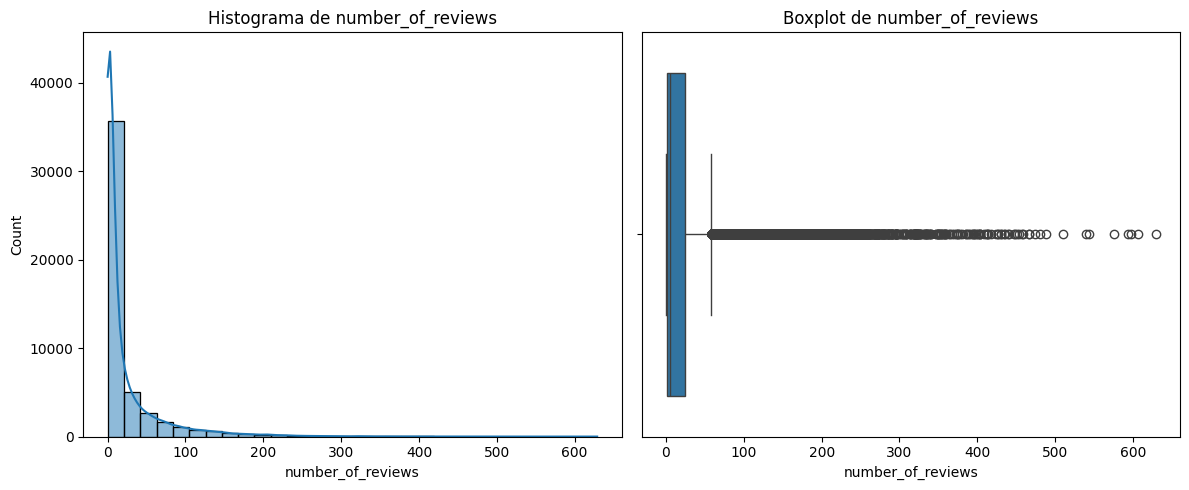

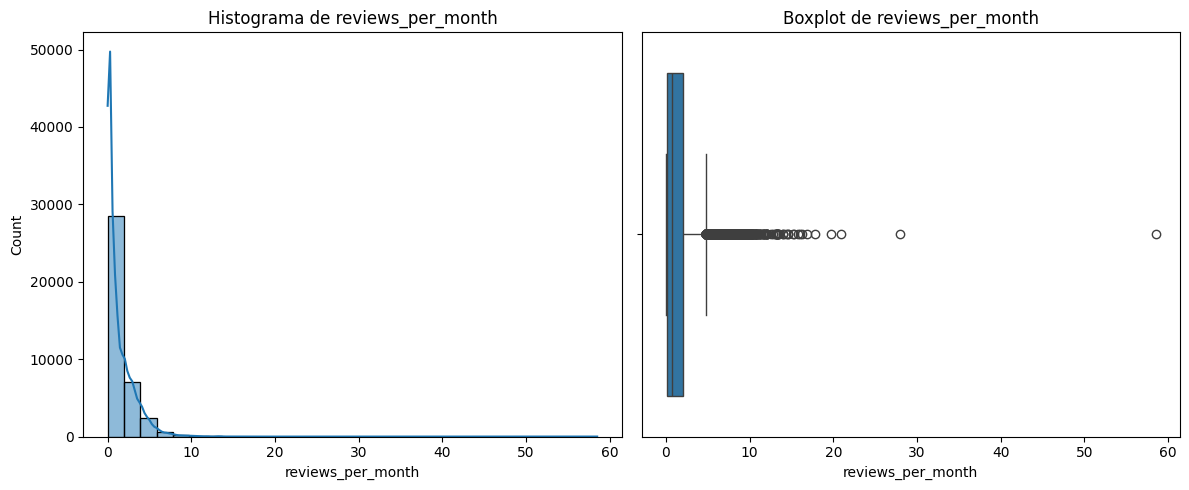

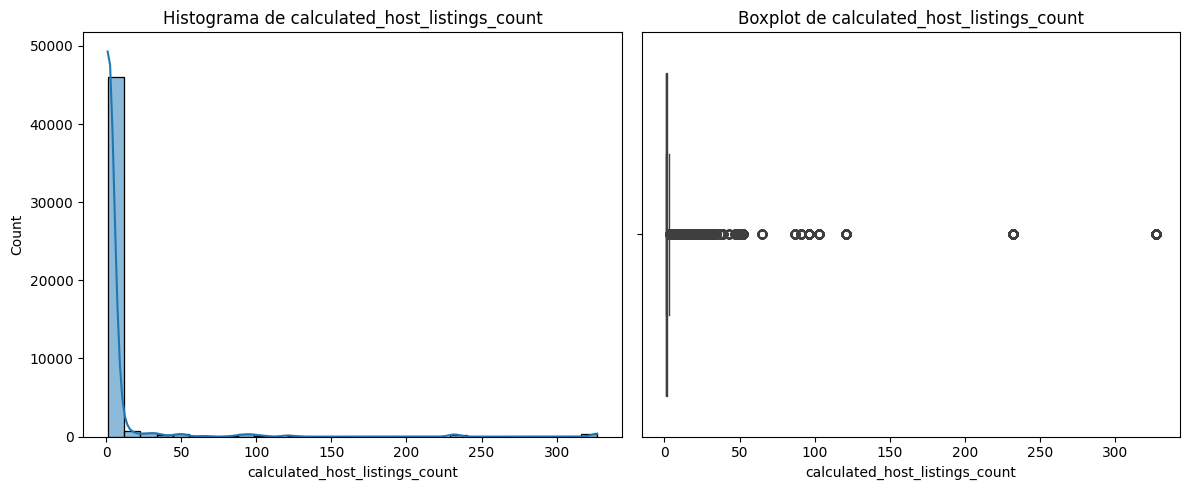

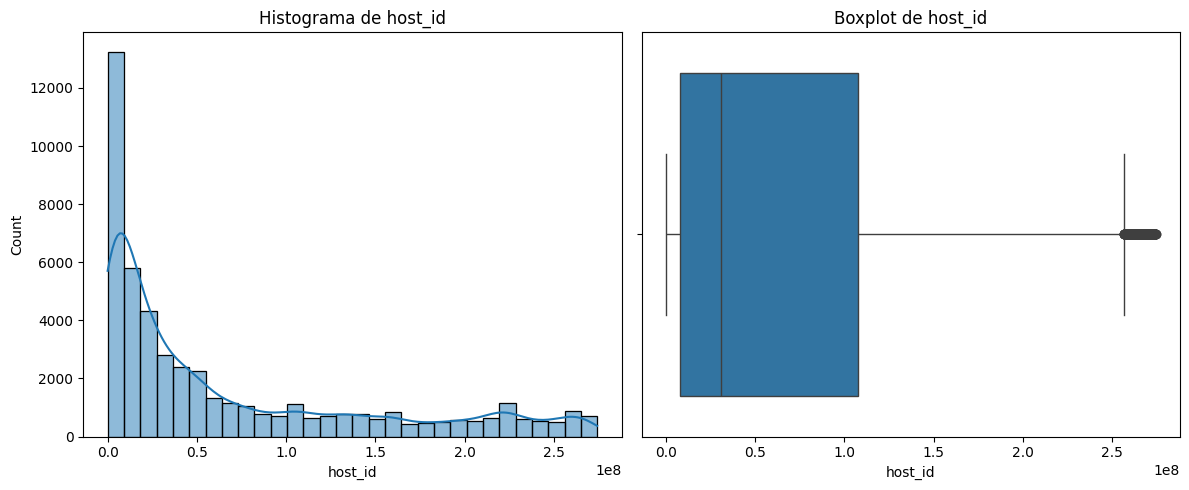

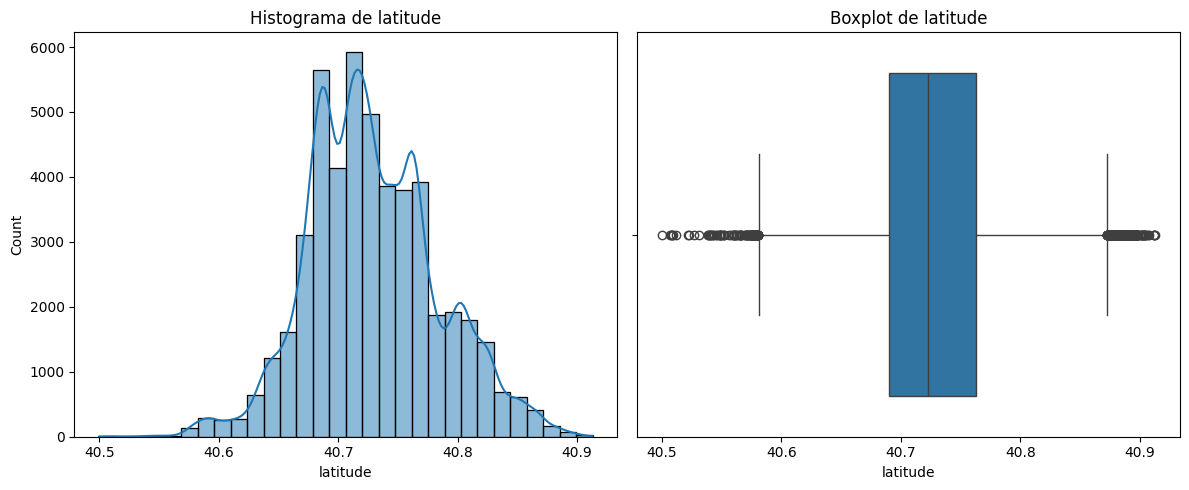

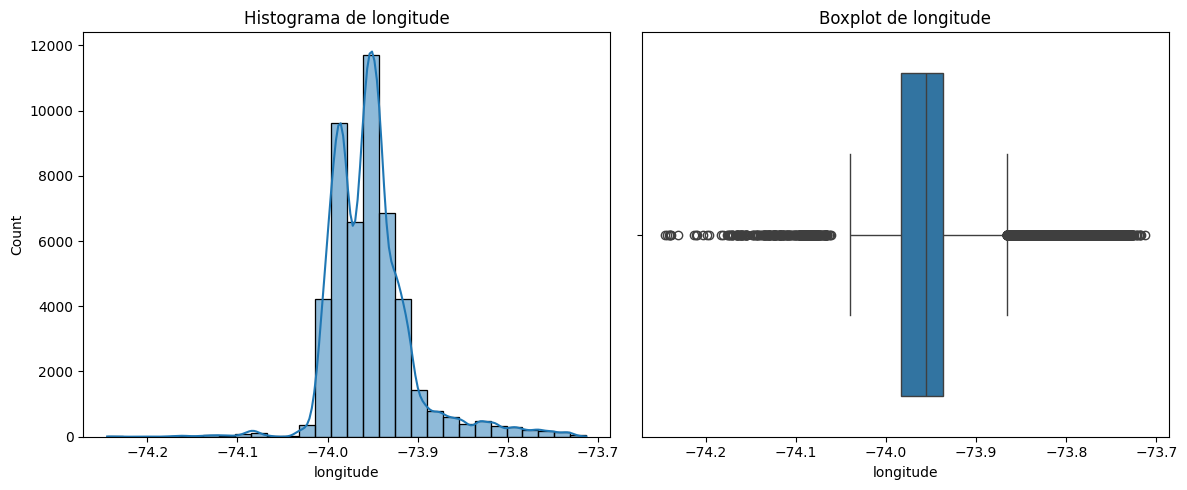

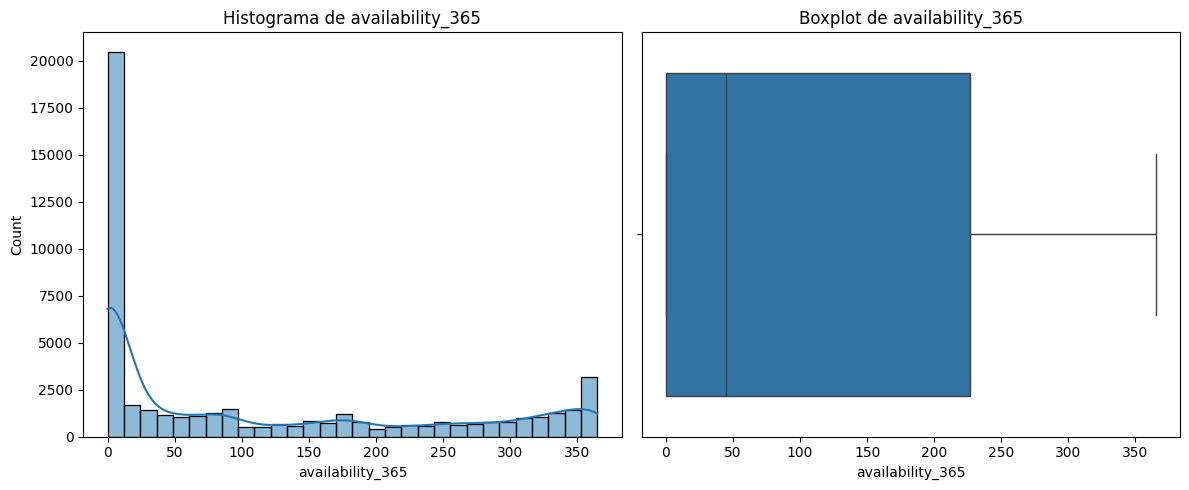

In [13]:
# Calculamos log_price (no añadimos 1 para evitar el logaritmo de cero porque ya henos eliminado las filas con price == 0)
df_inter.loc[:, 'log_price'] = np.log(df_inter['price'])

# Lista de variables para visualizar
num_variables = ['price', 'log_price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month','calculated_host_listings_count','host_id','latitude', 'longitude', 'availability_365' ]

# Crear histogramas y boxplots para cada variable
for var in num_variables:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df_inter[var], bins=30, kde=True)
    plt.title(f'Histograma de {var}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_inter[var])
    plt.title(f'Boxplot de {var}')

    plt.tight_layout()
    plt.show()

Vemos que el precio se asemeja mucho más a una distribución normal después de la transformación logarítmica.
Observamos que otras variables representadas se verían beneficiadas con una normalización y un estudio sobre los outliers.

In [14]:
df_inter.isnull().mean()*100

name                               0.032731
host_id                            0.000000
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.560920
reviews_per_month                 20.560920
calculated_host_listings_count     0.000000
availability_365                   0.000000
log_price                          0.000000
dtype: float64

<Axes: >

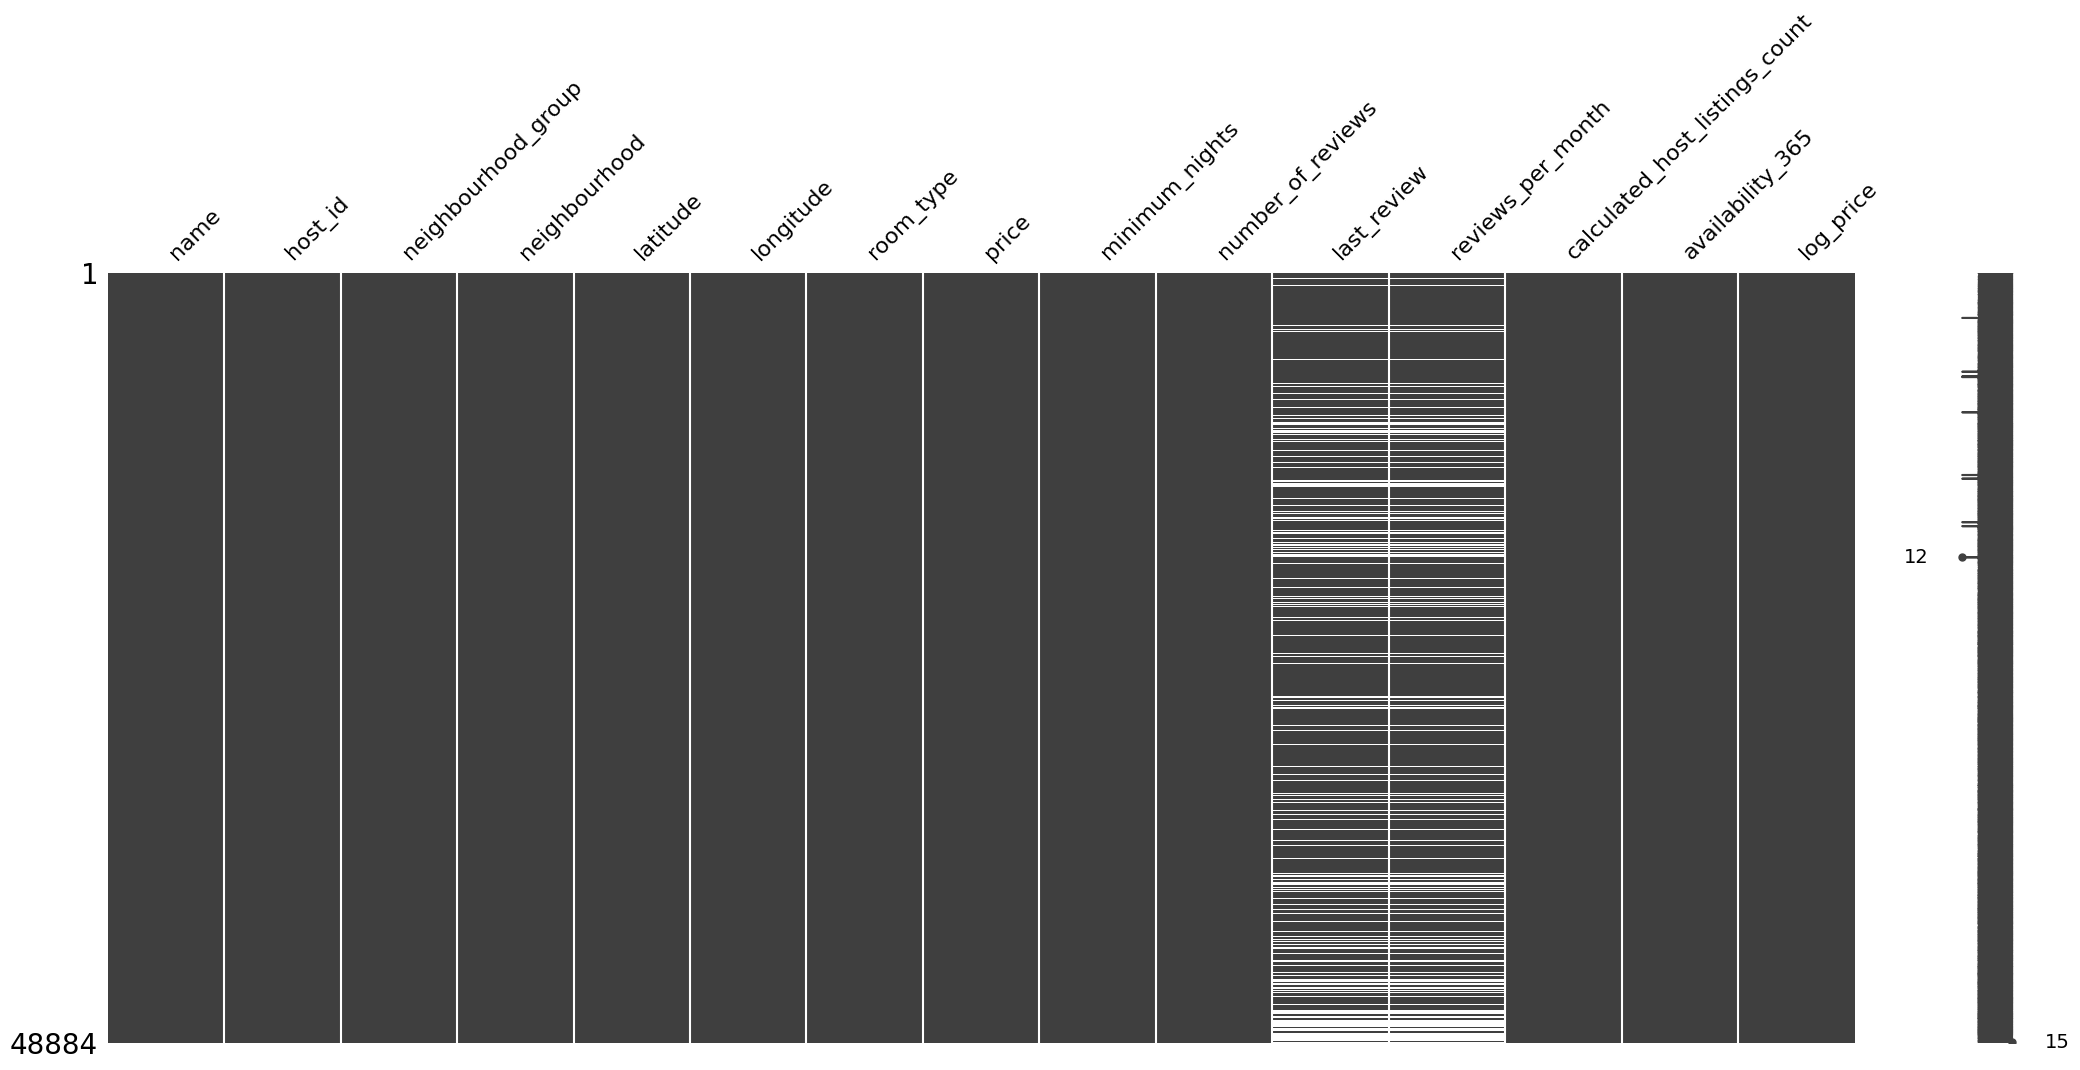

In [15]:
msno.matrix(df_inter)

Observamos un claro patrón en los datos faltantes (last_review y review_per_month). Las que carecen de un 'last_review' obviamente tienen 0 'reviews_per_month'. Podemos asignar el valor de 0 a todos los NaN de 'reviews_per_month' y poner la última fecha en 'last_review', para poder conservar esta columna.

In [16]:
df_inter.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price
count,4.888400e+04,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,38833.000000,48884.000000,48884.000000,48884.000000
mean,6.762203e+07,40.728953,-73.952176,152.755053,7.029887,23.271991,1.373128,7.144628,112.779498,4.727031
std,7.861666e+07,0.054532,0.046159,240.170260,20.512224,44.551331,1.680391,32.956185,131.627271,0.698225
min,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000,2.302585
25%,7.817310e+06,40.690100,-73.983080,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,4.234107
50%,3.079257e+07,40.723080,-73.955685,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,4.663439
75%,1.074344e+08,40.763120,-73.936290,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,5.164786
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,9.210340


In [17]:
# Asegurar que 'last_review' sea una columna de tipo datetime
df_inter['last_review'] = pd.to_datetime(df_inter['last_review'], errors='coerce')

# Encuentra la fecha más reciente, asegurándote de que realmente estás trabajando con fechas
max_date = df_inter['last_review'].max()

# Imputar 'last_review' con la fecha más reciente solo donde sea necesario
df_inter['last_review'] = df_inter['last_review'].fillna(max_date)

# Sustituir NaNs por 0 en 'reviews_per_month' usando una asignación directa, que es equivalente a usar loc aquí
df_inter['reviews_per_month'] = df_inter['reviews_per_month'].fillna(0)

# Verificar el porcentaje de valores nulos por columna
print(df_inter.isnull().mean() * 100)

name                              0.032731
host_id                           0.000000
neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.000000
reviews_per_month                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
log_price                         0.000000
dtype: float64


In [18]:
# Aplicando transformaciones logarítmicas
variables_to_log_transform = ['minimum_nights', 'calculated_host_listings_count']

# 
for var in variables_to_log_transform:
    df_inter[f'log_{var}'] = np.log(df_inter[var])

# Para 'number_of_reviews', 'reviews per month' y 'availability_365' añadir 1 antes de la transformación logarítmica de manera explícita
df_inter['log_number_of_reviews'] = np.log(df_inter['number_of_reviews'] + 1)
df_inter['log_reviews_per_month'] = np.log(df_inter['reviews_per_month'] + 1)
df_inter['log_availability_365'] = np.log(df_inter['availability_365'] + 1) 
print(df_inter.columns)

Index(['name', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'log_price',
       'log_minimum_nights', 'log_calculated_host_listings_count',
       'log_number_of_reviews', 'log_reviews_per_month',
       'log_availability_365'],
      dtype='object')


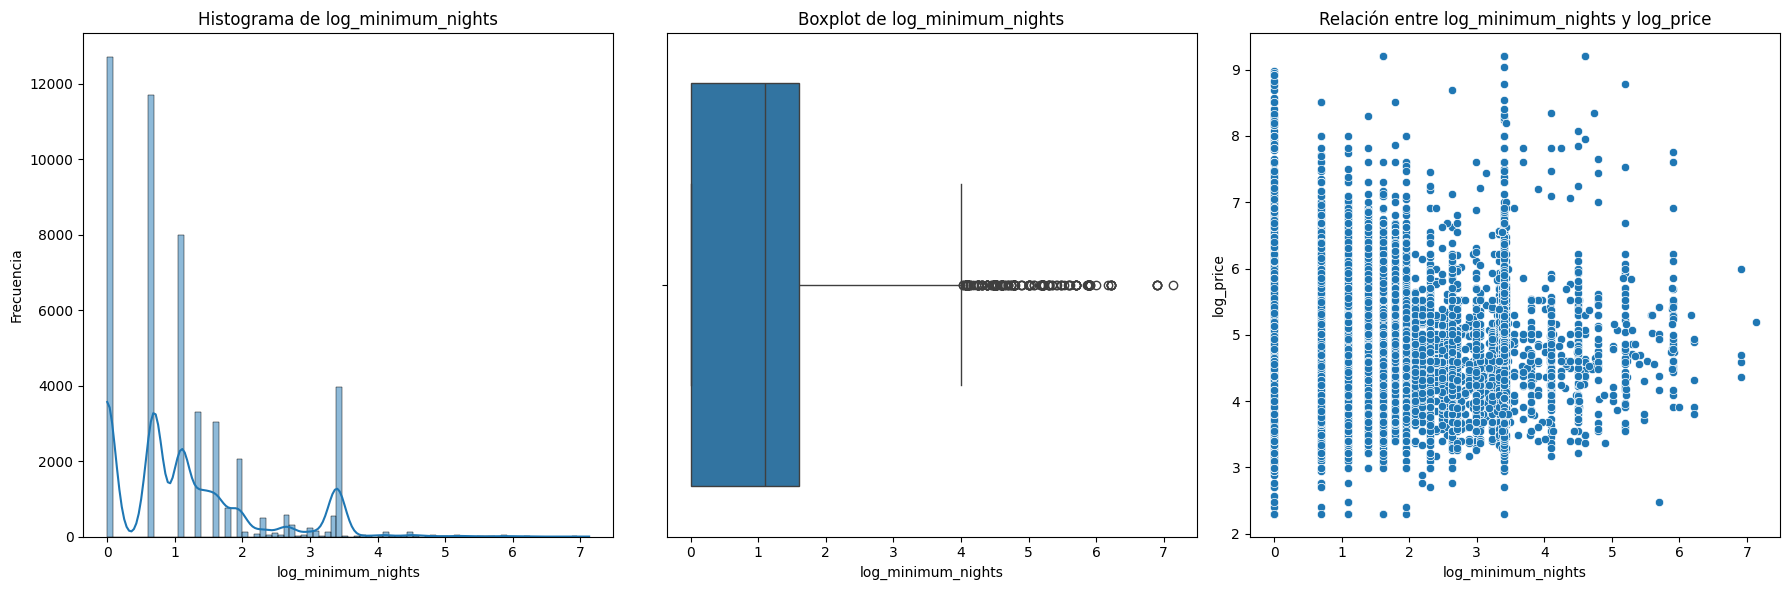

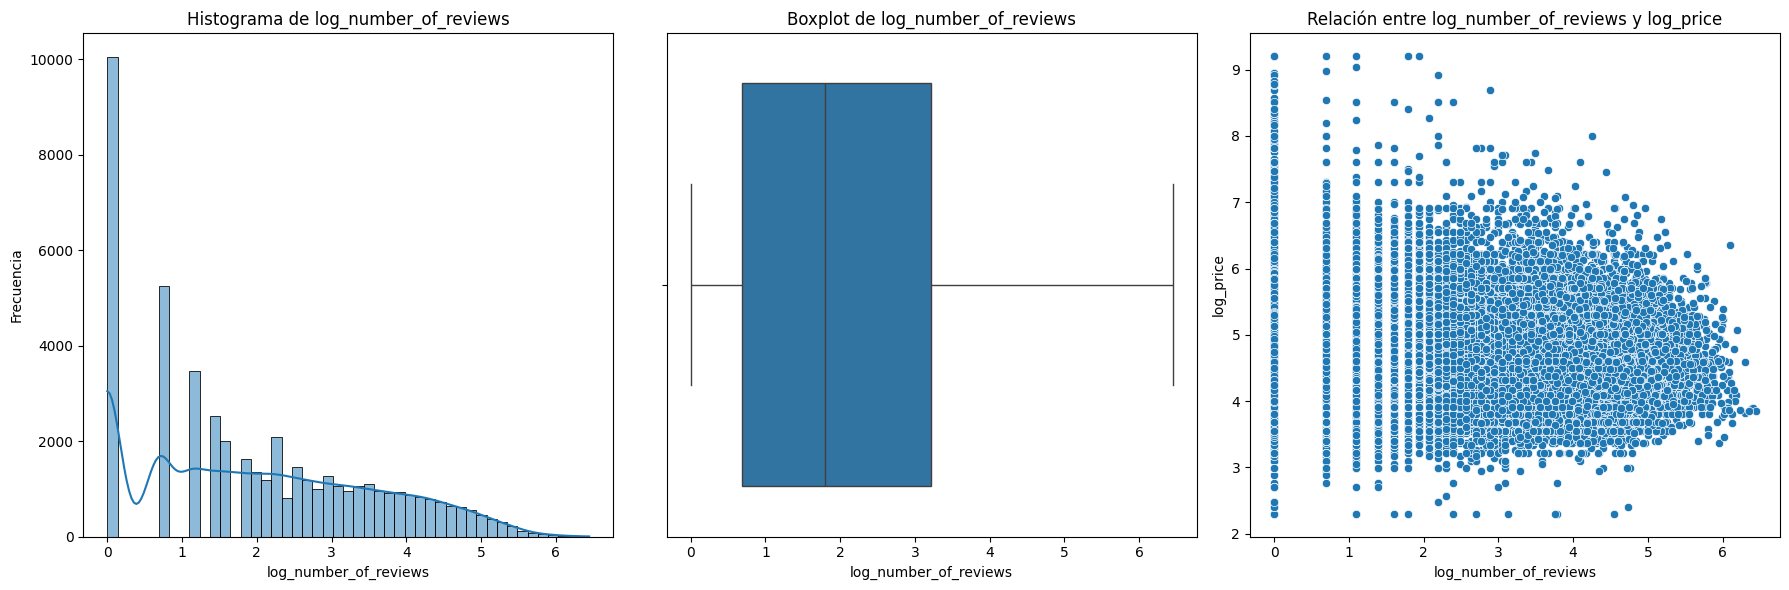

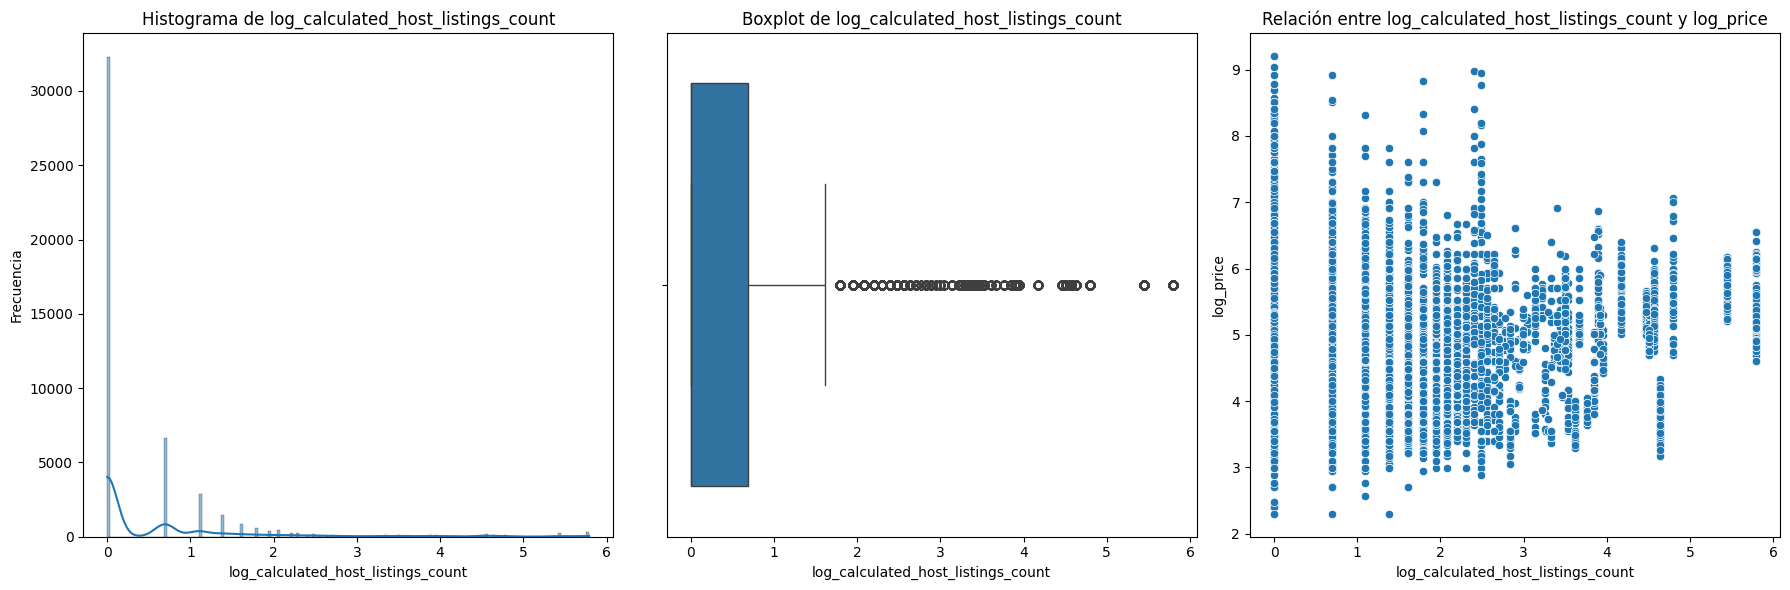

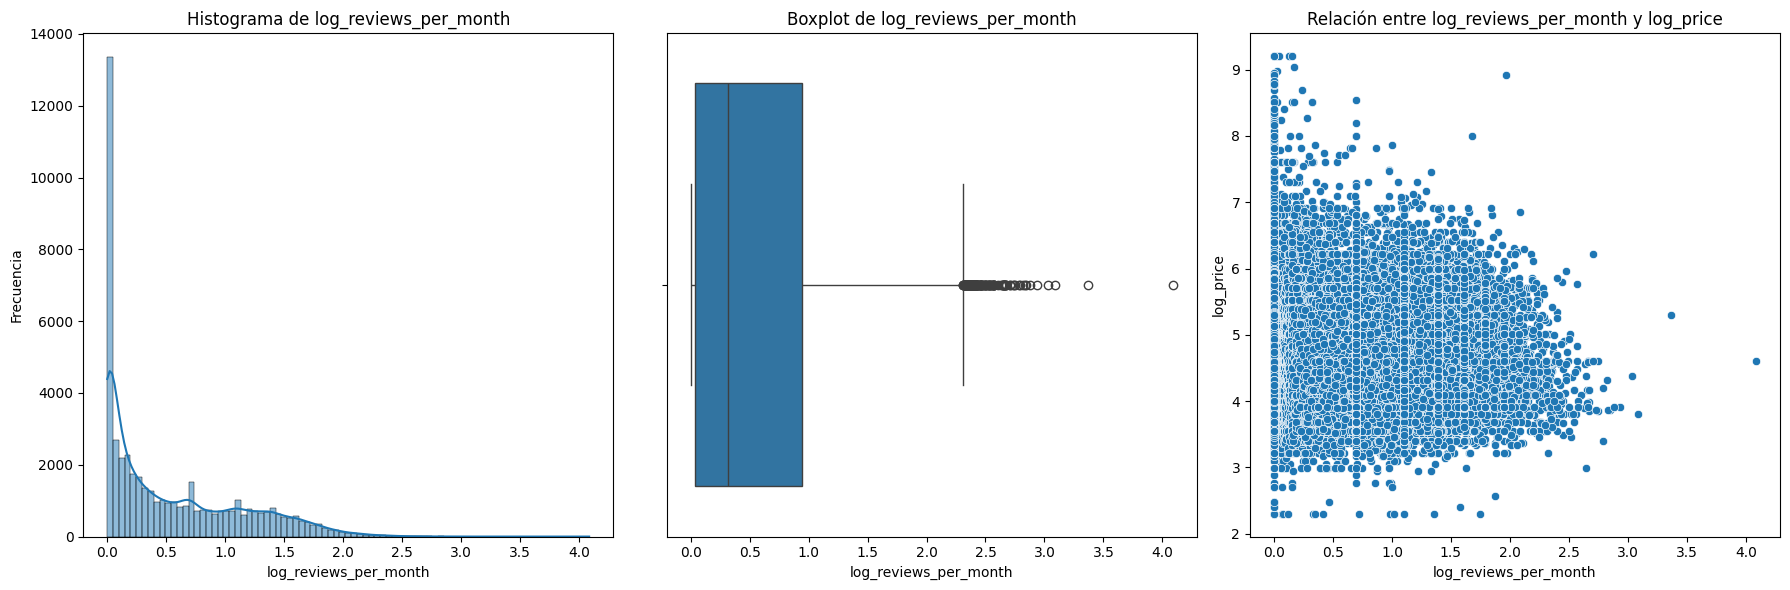

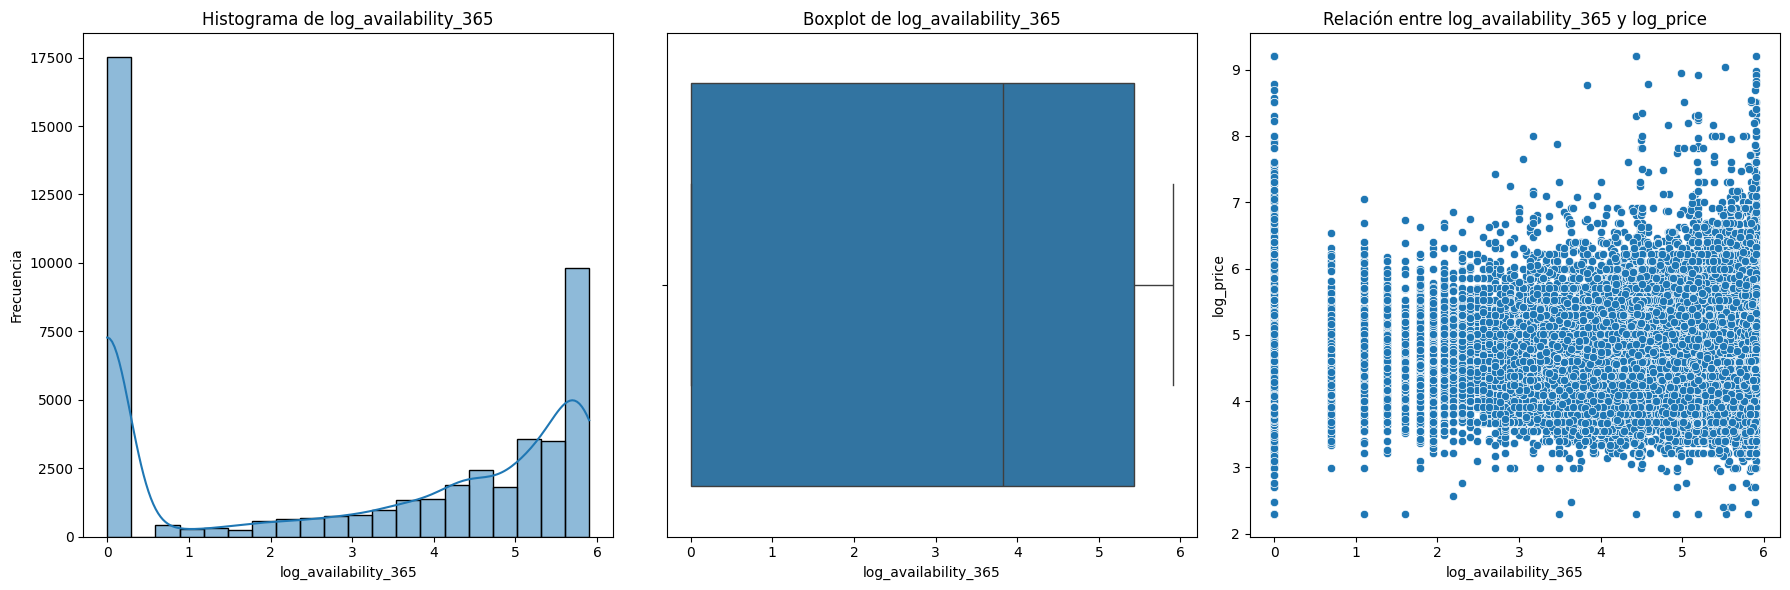

In [19]:
variables_to_compare = ['log_minimum_nights', 'log_number_of_reviews', 'log_calculated_host_listings_count','log_reviews_per_month', 'log_availability_365']

for var in variables_to_compare:
    # Configuración del layout para los gráficos
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Histograma
    sns.histplot(df_inter[var], kde=True, ax=ax[0])
    ax[0].set_title(f'Histograma de {var}')
    ax[0].set_xlabel(var)
    ax[0].set_ylabel('Frecuencia')
    
    # Boxplot
    sns.boxplot(x=df_inter[var], ax=ax[1])
    ax[1].set_title(f'Boxplot de {var}')
    ax[1].set_xlabel(var)
    
    # Gráfico de dispersión con respecto a log_price
    sns.scatterplot(data=df_inter, x=var, y='log_price', ax=ax[2])
    ax[2].set_title(f'Relación entre {var} y log_price')
    ax[2].set_xlabel(var)
    ax[2].set_ylabel('log_price')
    
    plt.tight_layout()
    plt.show()

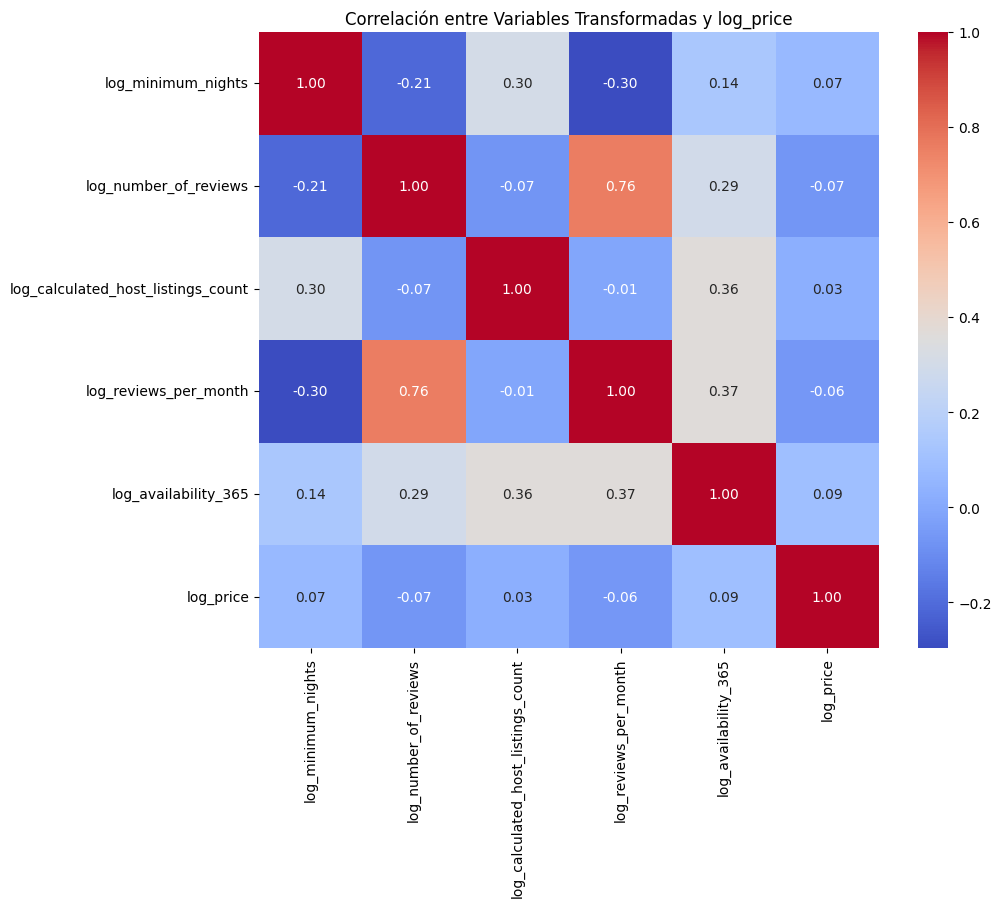

In [20]:
# Incluye 'log_price' en la lista de variables para el cálculo de correlación
variables_transformed_with_price = variables_to_compare + ['log_price']

# Calcular la matriz de correlación
corr_matrix = df_inter[variables_transformed_with_price].corr()

# Generar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre Variables Transformadas y log_price')
plt.show()

La correlación más fuerte es entre number_of_reviews y reviews_per_month, lo cual es lógico.
Availability_365 se correlaciona con varias variables.
Observamos cierta correlación positiva entre minimum_nights y calculated_host_listing
También una pequeña correlación negativa entre number_reviews y minimum_nights
Sin embargo, ninguna de las variables estudiadas guarda una correlación significativa con el precio.

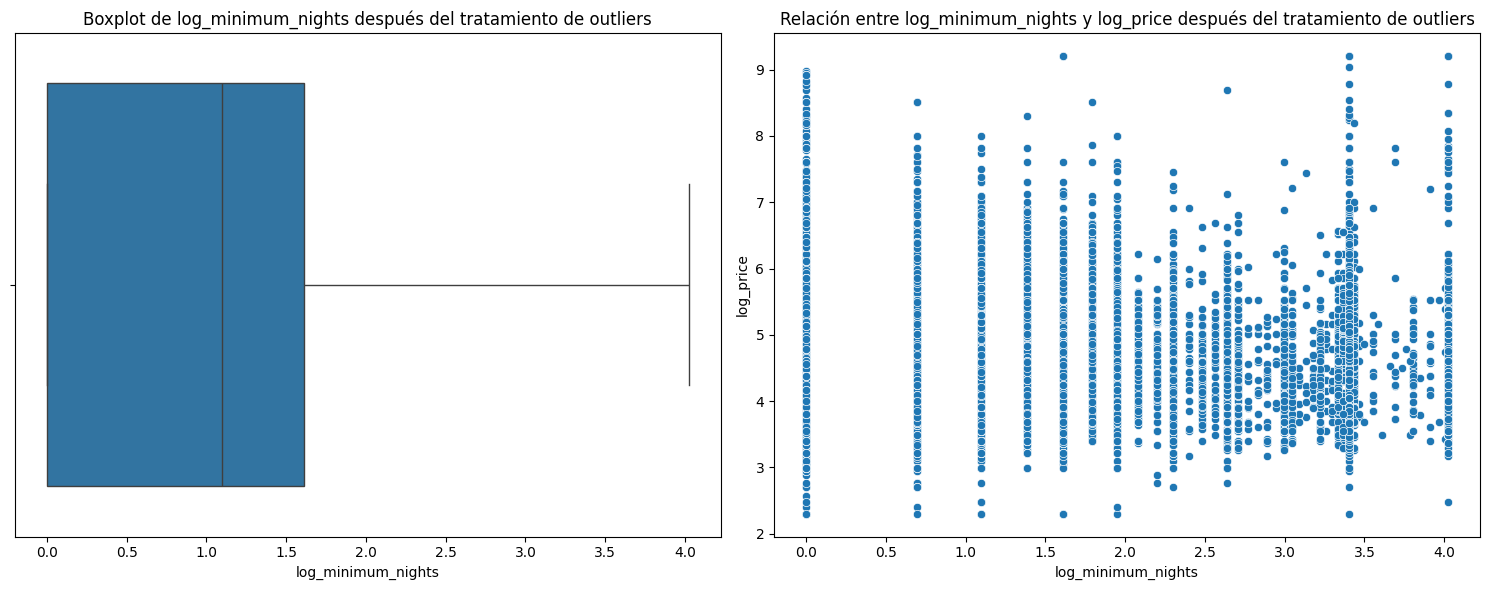

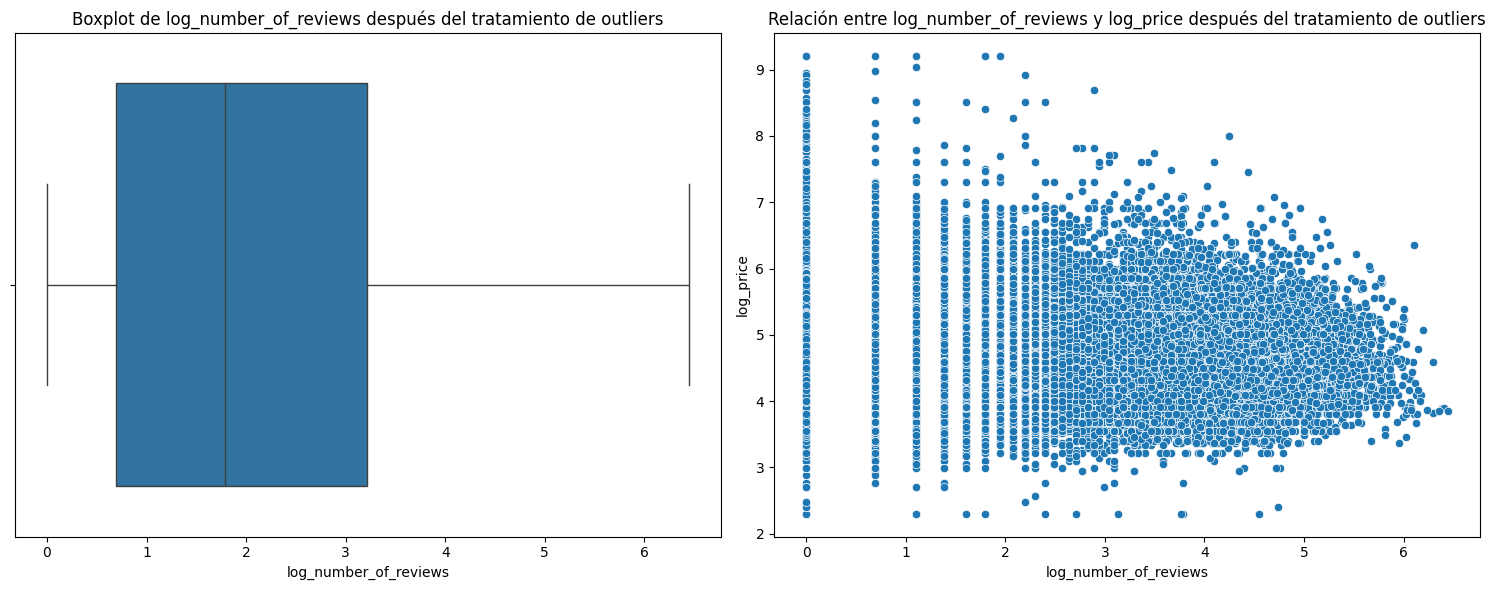

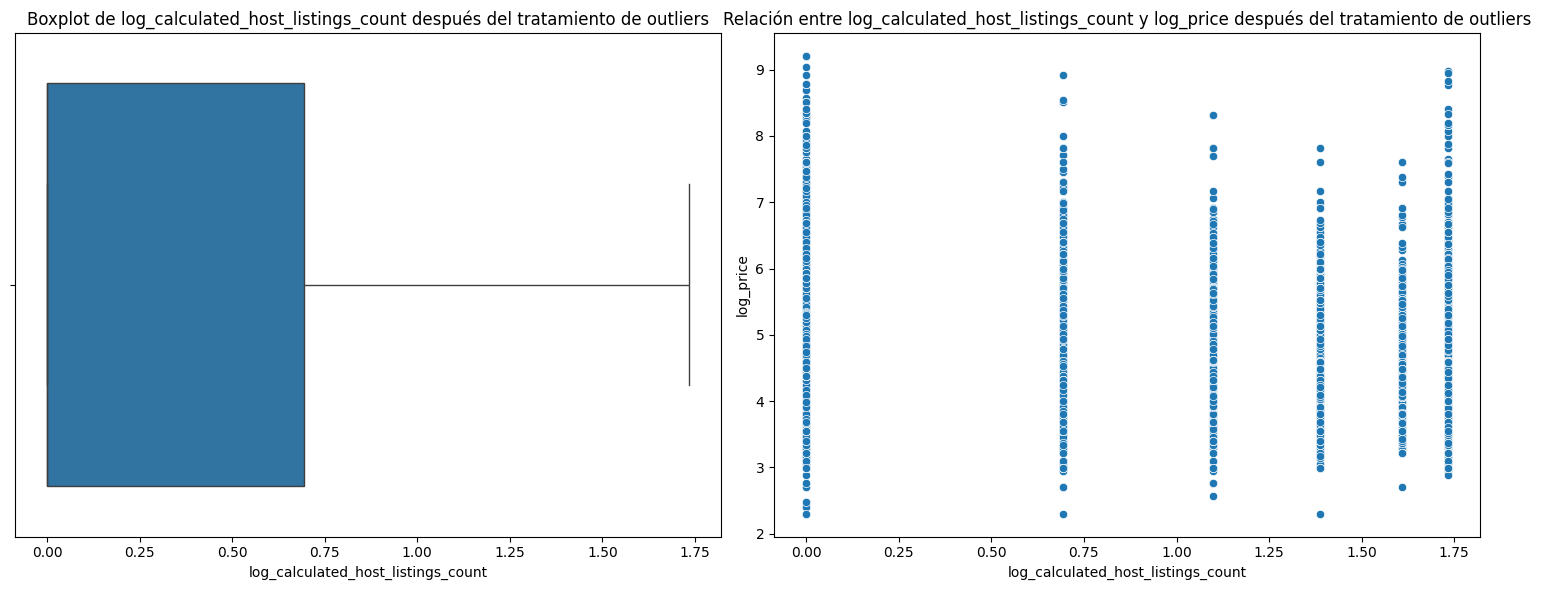

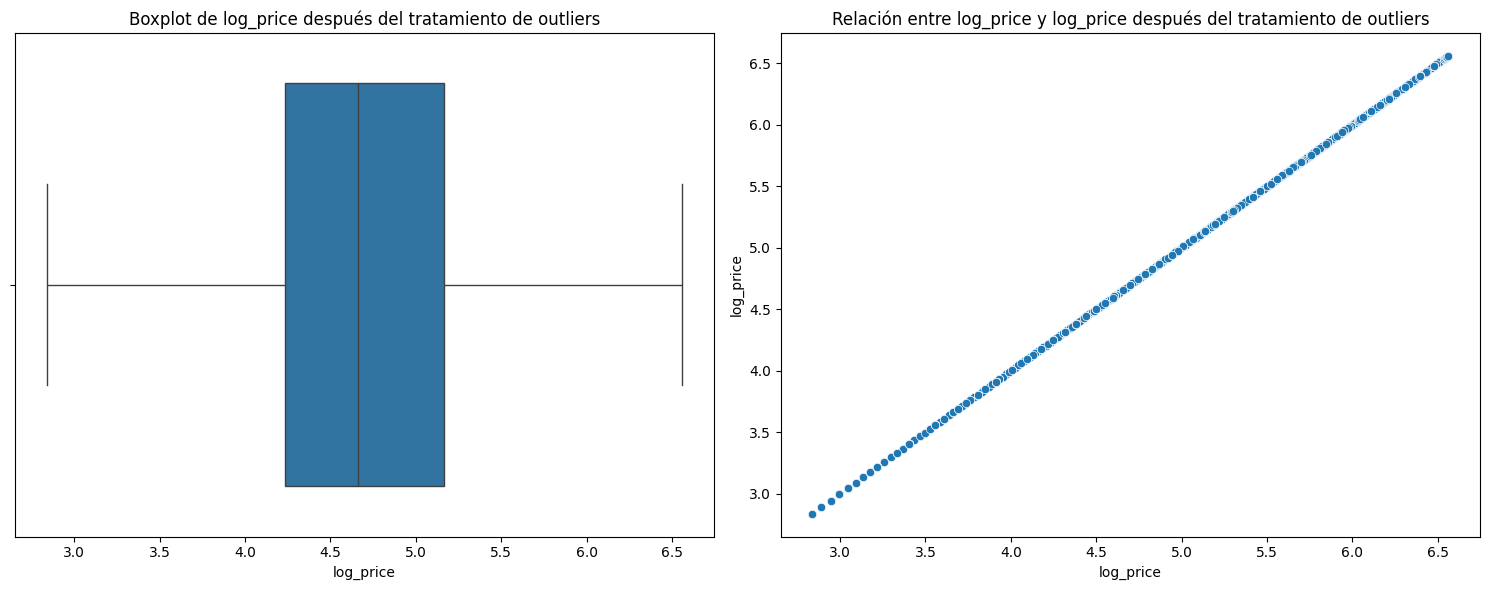

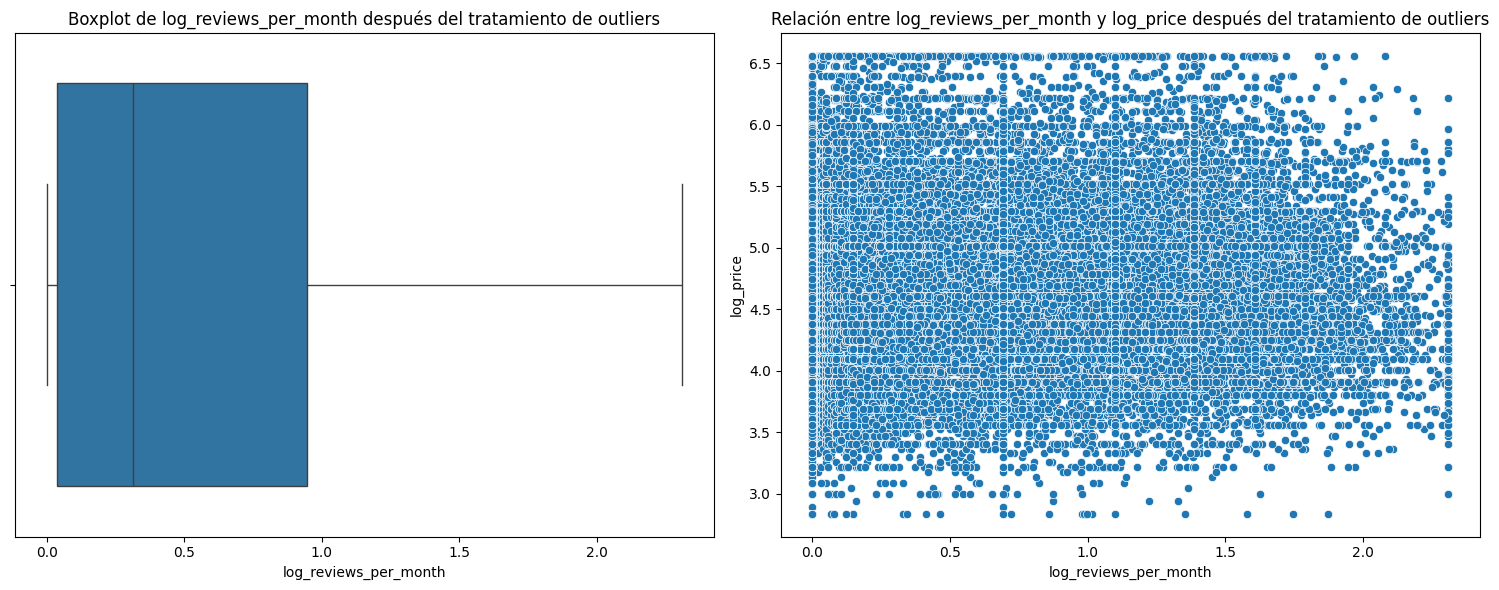

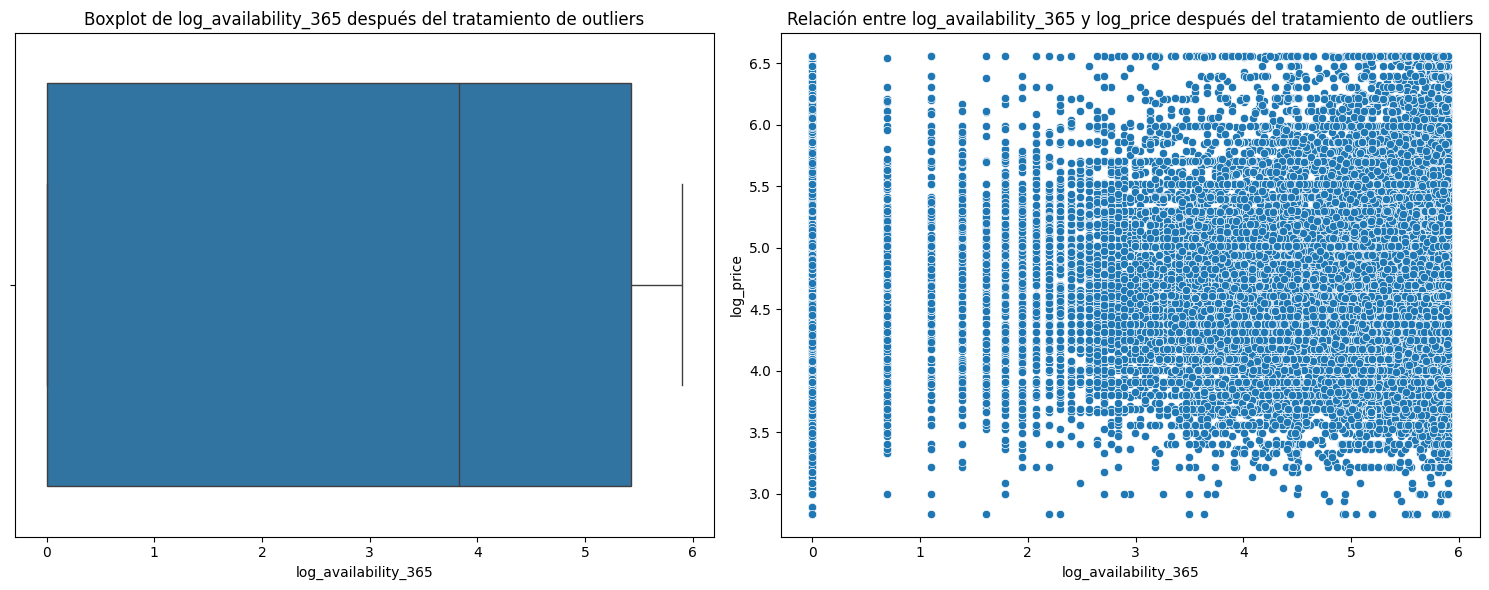

In [21]:
variables_transformed = ['log_minimum_nights', 'log_number_of_reviews', 'log_calculated_host_listings_count', 'log_price', 'log_reviews_per_month', 'log_availability_365']

# Hacemos una copia para mantener los datos originales
df_original = df_inter.copy()

# Creamos un nuevo DataFrame para el tratamiento de outliers
df_inter = df_original.copy()


for var in variables_transformed:
    Q1 = df_inter[var].quantile(0.25)
    Q3 = df_inter[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Opción 1: Eliminar outliers
    # df_inter = df_inter[(df_inter[var] >= lower_bound) & (df_inter[var] <= upper_bound)]

    # Opción 2: Winsorizar outliers
    df_inter.loc[df_inter[var] > upper_bound, var] = upper_bound
    df_inter.loc[df_inter[var] < lower_bound, var] = lower_bound

    # Visualización después del tratamiento de outliers
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    sns.boxplot(x=df_inter[var], ax=axs[0])
    axs[0].set_title(f'Boxplot de {var} después del tratamiento de outliers')
    sns.scatterplot(x=df_inter[var], y=df_inter['log_price'], ax=axs[1])
    axs[1].set_title(f'Relación entre {var} y log_price después del tratamiento de outliers')
    plt.tight_layout()
    plt.show()

    df_original.to_csv(os.path.join(directory_inter, 'dataframe_original.csv'), index=False)
    df_inter.to_csv(os.path.join(directory_inter, 'dataframe_inter.csv'), index=False)

In [22]:
df_inter.nunique()

name                                  47894
host_id                               37455
neighbourhood_group                       5
neighbourhood                           221
latitude                              19046
longitude                             14715
room_type                                 3
price                                   673
minimum_nights                          109
number_of_reviews                       394
last_review                            1764
reviews_per_month                       938
calculated_host_listings_count           47
availability_365                        366
log_price                               511
log_minimum_nights                       47
log_calculated_host_listings_count        6
log_number_of_reviews                   394
log_reviews_per_month                   827
log_availability_365                    366
dtype: int64

In [23]:
variables_numericas = [
    'latitude',
    'longitude',
    'log_price',
    'log_minimum_nights',
    'log_calculated_host_listings_count',
    'log_number_of_reviews',
    'log_reviews_per_month',
    'log_availability_365'
]

# Creando un nuevo DataFrame solo con las variables numéricas seleccionadas
df_numericas = df_inter[variables_numericas]

# Mostrar las primeras filas del nuevo DataFrame para verificar
print(df_numericas.head())

   latitude  longitude  log_price  log_minimum_nights  \
0  40.64749  -73.97237   5.003946            0.000000   
1  40.75362  -73.98377   5.416100            0.000000   
2  40.80902  -73.94190   5.010635            1.098612   
3  40.68514  -73.95976   4.488636            0.000000   
4  40.79851  -73.94399   4.382027            2.302585   

   log_calculated_host_listings_count  log_number_of_reviews  \
0                            1.732868               2.302585   
1                            0.693147               3.828641   
2                            0.000000               0.000000   
3                            0.000000               5.602119   
4                            0.000000               2.302585   

   log_reviews_per_month  log_availability_365  
0               0.190620              5.902633  
1               0.322083              5.874931  
2               0.000000              5.902633  
3               1.729884              5.273000  
4               0.095310   

In [24]:
variables_categoricas = ['neighbourhood_group', 'neighbourhood', 'room_type']
df_categoricas = df_inter[variables_categoricas]

print(df_categoricas.head())

  neighbourhood_group neighbourhood        room_type
0            Brooklyn    Kensington     Private room
1           Manhattan       Midtown  Entire home/apt
2           Manhattan        Harlem     Private room
3            Brooklyn  Clinton Hill  Entire home/apt
4           Manhattan   East Harlem  Entire home/apt


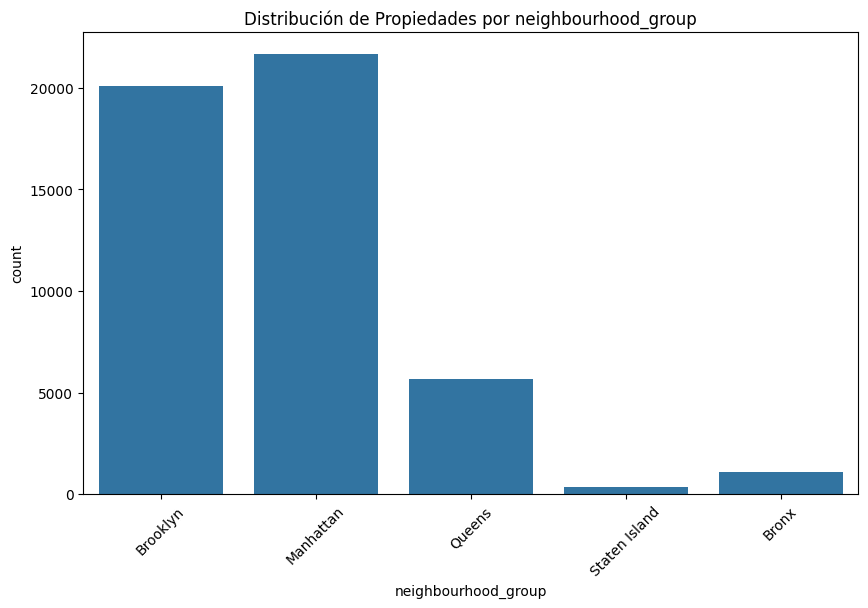

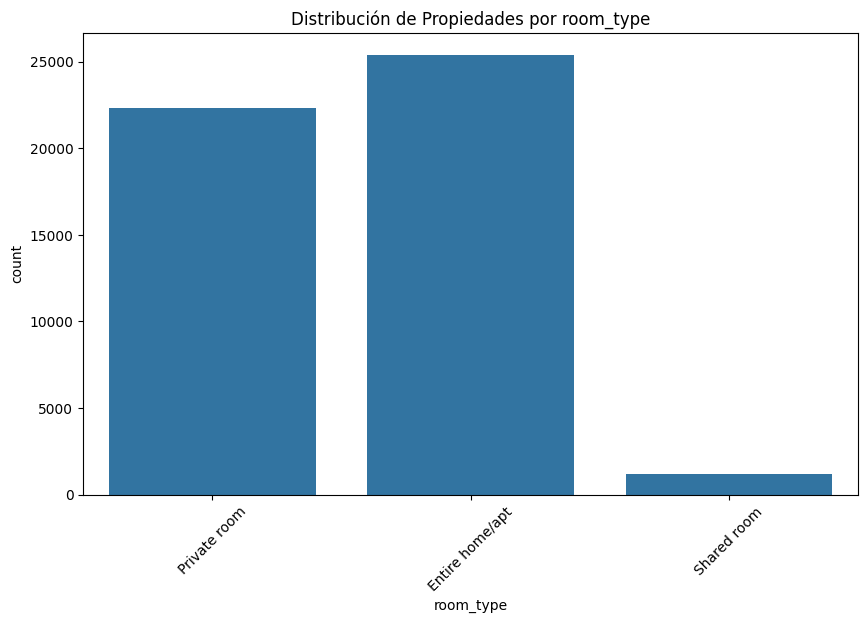

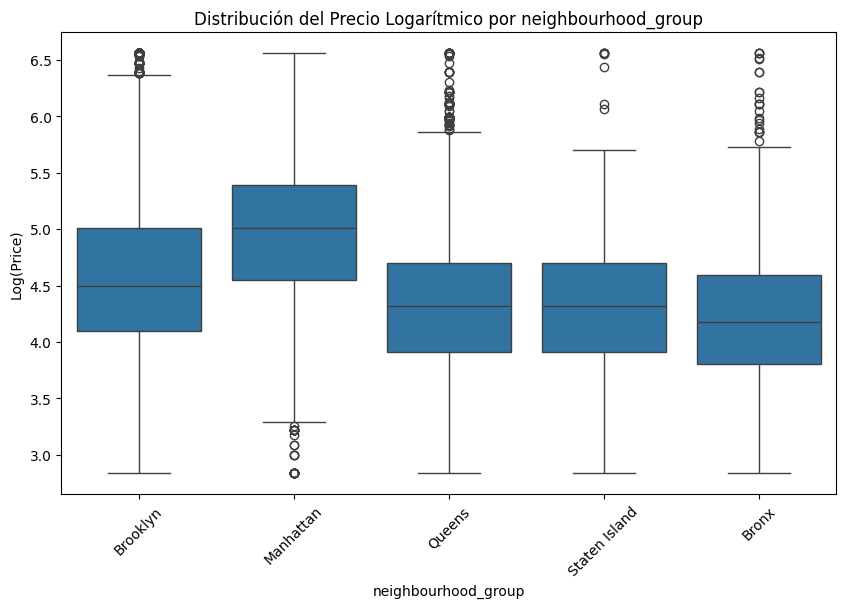

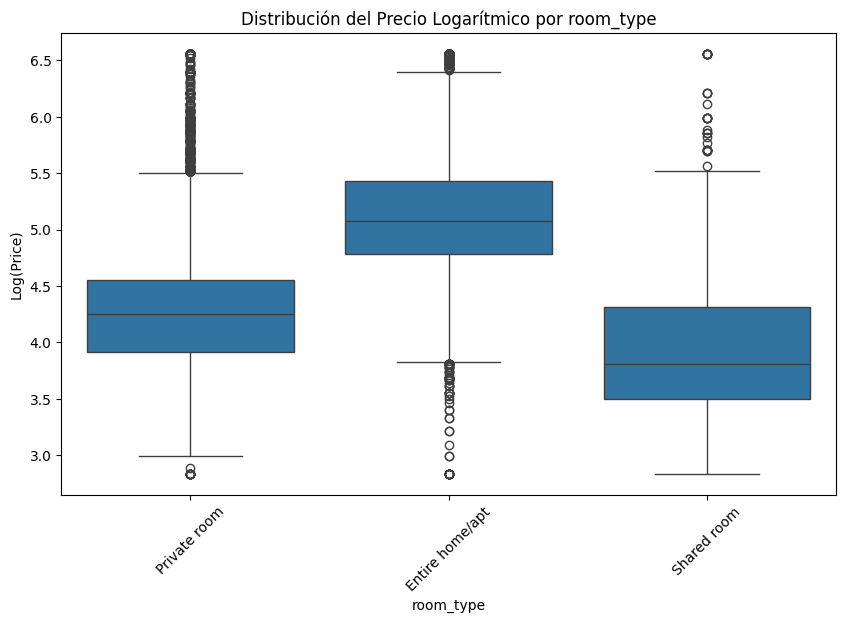

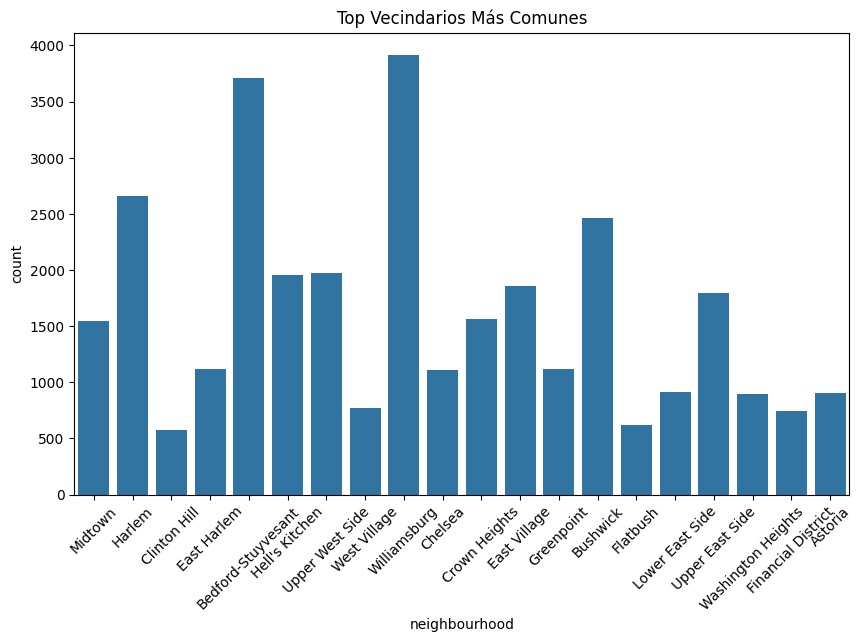

In [25]:
# Visualización de la distribución de cada variable categórica
variables_categoricas = ['neighbourhood_group', 'room_type']  # Agregar 'neighbourhood' no sé si es práctico (saldrían excesivas categorías)

for variable in variables_categoricas:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_categoricas, x=variable)
    plt.title(f'Distribución de Propiedades por {variable}')
    plt.xticks(rotation=45)
    plt.show()

# Visualización de 'log_price' por cada variable categórica
for variable in variables_categoricas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_inter, x=variable, y='log_price')
    plt.title(f'Distribución del Precio Logarítmico por {variable}')
    plt.ylabel('Log(Price)')
    plt.xticks(rotation=45)
    plt.show()

# Nota: Para 'neighbourhood', visualizamos sólo los 20 primeros porque son muchos
if 'neighbourhood' in df_categoricas:
    top_neighbourhoods = df_categoricas['neighbourhood'].value_counts().head(20).index
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_categoricas[df_categoricas['neighbourhood'].isin(top_neighbourhoods)], x='neighbourhood')
    plt.title('Top Vecindarios Más Comunes')
    plt.xticks(rotation=45)
    plt.show()

In [26]:
df_onehot = pd.get_dummies(df_inter, columns=['neighbourhood_group', 'neighbourhood', 'room_type'])

print(df_onehot.head())

                                               name  host_id  latitude  \
0                Clean & quiet apt home by the park     2787  40.64749   
1                             Skylit Midtown Castle     2845  40.75362   
2               THE VILLAGE OF HARLEM....NEW YORK !     4632  40.80902   
3                   Cozy Entire Floor of Brownstone     4869  40.68514   
4  Entire Apt: Spacious Studio/Loft by central park     7192  40.79851   

   longitude  price  minimum_nights  number_of_reviews last_review  \
0  -73.97237    149               1                  9  2018-10-19   
1  -73.98377    225               1                 45  2019-05-21   
2  -73.94190    150               3                  0  2019-07-08   
3  -73.95976     89               1                270  2019-07-05   
4  -73.94399     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  \
0               0.21                               6        

In [27]:
print(df_onehot.dtypes)

name                          object
host_id                        int64
latitude                     float64
longitude                    float64
price                          int64
                              ...   
neighbourhood_Woodrow           bool
neighbourhood_Woodside          bool
room_type_Entire home/apt       bool
room_type_Private room          bool
room_type_Shared room           bool
Length: 246, dtype: object


In [28]:
# Convertir columnas booleanas a enteros (1s y 0s)
for column in df_onehot.columns:
    if df_onehot[column].dtype == 'bool':
        df_onehot[column] = df_onehot[column].astype(int)
print(df_onehot.dtypes)

name                          object
host_id                        int64
latitude                     float64
longitude                    float64
price                          int64
                              ...   
neighbourhood_Woodrow          int64
neighbourhood_Woodside         int64
room_type_Entire home/apt      int64
room_type_Private room         int64
room_type_Shared room          int64
Length: 246, dtype: object


In [29]:
# Buscar cadenas de palabras relevantes
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Instanciar el CountVectorizer con ajustes de frecuencia y un token_pattern que excluya números
vectorizer = CountVectorizer(stop_words=stop_words, min_df=100, max_df=0.7, 
                             token_pattern=r'\b[a-zA-Z]+\b', ngram_range = (2,4))  # Solo acepta palabras que contienen letras

# Ajuste y transformación de los nombres
V = vectorizer.fit_transform(df_inter['name'].fillna(''))

# Convertir a DataFrame las palabras clave
keywords_temp = pd.DataFrame(V.toarray(), columns=vectorizer.get_feature_names_out())

# Generar un conjunto de palabras únicas presentes en los nombres de las columnas de interés
columnas_de_interes = [col.split('_')[-1].lower() for col in df_inter.columns 
                       if 'neighbourhood_group_' in col or 'neighbourhood_' in col]
palabras_unicas_de_columnas = set(columnas_de_interes)

# Filtrar palabras clave que no coinciden con las palabras únicas de las columnas de interés
# y que no contienen números
keywords_filtradas = [col for col in keywords_temp.columns 
                      if col not in palabras_unicas_de_columnas and not re.search(r'\d', col)]

# Actualizar 'keywords' para incluir solo las palabras clave filtradas
keywords = keywords_temp[keywords_filtradas]
print(keywords)

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


       apartment brooklyn  apartment heart  apartment near  \
0                       0                0               0   
1                       0                0               0   
2                       0                0               0   
3                       0                0               0   
4                       0                0               0   
...                   ...              ...             ...   
48879                   0                0               0   
48880                   0                0               0   
48881                   0                0               0   
48882                   0                0               0   
48883                   0                0               0   

       apartment williamsburg  apt heart  apt near  apt w  artist loft  \
0                           0          0         0      0            0   
1                           0          0         0      0            0   
2                           0    

In [30]:
# Asegurarse de que 'log_price' no esté duplicada antes de concatenar
if 'log_price' in df_numericas.columns and 'log_price' in df_onehot.columns:
    df_onehot = df_onehot.drop(['log_price'], axis=1)

# Combinamos en un df
df_final = pd.concat([df_numericas, df_onehot, keywords], axis=1)
# Crear una copia del DataFrame para reducir la fragmentación (opcional, para mejorar el rendimiento)
df_final = df_final.copy()

# Asegúrate de que 'last_review' esté en formato datetime antes de proceder
if 'last_review' in df_final.columns:
    df_final['last_review'] = pd.to_datetime(df_final['last_review'], errors='coerce')
    df_final['last_review_year'] = df_final['last_review'].dt.year
    most_recent_date = df_final['last_review'].max()
    df_final['days_since_last_review'] = (most_recent_date - df_final['last_review']).dt.days
    df_final.drop('last_review', axis=1, inplace=True)

# Limpieza adicional para asegurar la ausencia de NaNs en columnas relevantes
df_final_cleaned = df_final.dropna()

# Verificar si 'log_price' está duplicada en 'df_final'
#print("Número de columnas 'log_price' en df_final:", df_final.columns.tolist().count('log_price'))

# Dividir los datos en características (X) y la variable objetivo (y)
X = df_final_cleaned.drop(['log_price', 'name'], axis=1)
y = df_final_cleaned['log_price']
print(f"Tipo de 'y' al seleccionar 'log_price': {type(y)}")  # Asegurándonos de que y sea una Serie

# Proceder con la división en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificación y corrección explícita del tipo de 'y_train' si es necesario
if not isinstance(y_train, pd.Series):
    y_train = y_train.squeeze()  # Convertir a Serie si 'y_train' no es una Serie

print(f"y_train type after correction: {type(y_train)}")

Tipo de 'y' al seleccionar 'log_price': <class 'pandas.core.series.Series'>
y_train type after correction: <class 'pandas.core.series.Series'>


In [31]:
# Verifica los tipos de datos en X_train
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39085 entries, 24027 to 15807
Columns: 460 entries, latitude to days_since_last_review
dtypes: float64(460)
memory usage: 137.5 MB


In [32]:
# Reducir el tamaño de los datos
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [33]:
# Identificar las columnas duplicadas por nombre
duplicated_columns = X_train.columns[X_train.columns.duplicated()]

# Mostrar las columnas duplicadas
print("Columnas duplicadas:", duplicated_columns)

# Eliminar las columnas duplicadas
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

Columnas duplicadas: Index(['latitude', 'longitude', 'log_minimum_nights',
       'log_calculated_host_listings_count', 'log_number_of_reviews',
       'log_reviews_per_month', 'log_availability_365'],
      dtype='object')


In [34]:
pd.set_option('display.max_seq_items', None)

# Imprimir los nombres de las columnas
print(X_train.columns)
print(X_test.columns)

Index(['latitude', 'longitude', 'log_minimum_nights',
       'log_calculated_host_listings_count', 'log_number_of_reviews',
       'log_reviews_per_month', 'log_availability_365', 'host_id', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn',
       'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens',
       'neighbourhood_group_Staten Island', 'neighbourhood_Allerton',
       'neighbourhood_Arden Heights', 'neighbourhood_Arrochar',
       'neighbourhood_Arverne', 'neighbourhood_Astoria',
       'neighbourhood_Bath Beach', 'neighbourhood_Battery Park City',
       'neighbourhood_Bay Ridge', 'neighbourhood_Bay Terrace',
       'neighbourhood_Bay Terrace, Staten Island', 'neighbourhood_Baychester',
       'neighbourhood_Bayside', 'neighbourhood_Bayswater',
       'neighbourhood_Bedford-Stuyvesant', 'neighbourhood_Belle Harbor',

In [35]:
# Eliminar las columnas especificadas de X_train y X_test
X_train.drop(['minimum_nights', 'calculated_host_listings_count', 'availability_365'], axis=1, inplace=True)
X_test.drop(['minimum_nights', 'calculated_host_listings_count', 'availability_365'], axis=1, inplace=True)

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


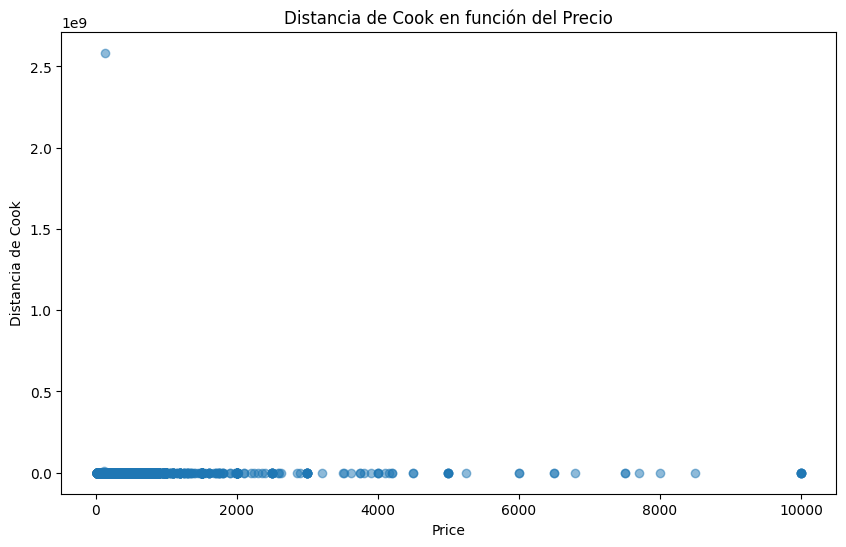

In [36]:
# Ajusta el modelo con X_train para evitar data leakage
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()

# Obtención de la influencia del modelo y cálculo de la distancia de Cook para cada observación
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Visualización
plt.figure(figsize=(10, 6))
plt.scatter(X_train['price'], cooks_d, alpha=0.5)  # Asegúrate de ajustar si 'price' no está en X_train
plt.xlabel('Price')
plt.ylabel('Distancia de Cook')
plt.title('Distancia de Cook en función del Precio')
plt.show()

#Quitamos price para que los modelos que entrenemos a partir de ahora no tengan los datos viciados.
X_train = X_train.drop(['price'], axis=1)
X_test = X_test.drop(['price'], axis=1)
X = X.drop(['price'], axis=1)

In [37]:
# Definir umbral para la distancia de Cook
n = X_train.shape[0]
influential_threshold = 4 / n

# Identificar índices de puntos con una distancia de Cook superior al umbral
influential_points = cooks_d > influential_threshold
influential_indices = np.where(influential_points)[0]

# Excluir estos puntos del conjunto de entrenamiento utilizando iloc
X_train = X_train.iloc[~X_train.index.isin(influential_indices)]
y_train = y_train.iloc[~y_train.index.isin(influential_indices)]

In [38]:
# Inicializa el escalador
scaler = MinMaxScaler()

# Ajusta el escalador solo en los datos de entrenamiento para evitar data leakage
X_train_scaled = scaler.fit_transform(X_train)

# Aplica la transformación a los datos de prueba
X_test_scaled = scaler.transform(X_test)

# Convierte el resultado a DataFrames para una manipulación más fácil
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [39]:
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ajustar el ancho para evitar el recorte
pd.set_option('display.max_colwidth', None)  # Mostrar contenido completo de las columnas

# Usar .info() para mostrar todos los detalles del DataFrame, incluyendo todas las columnas y sus tipos
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48857 entries, 0 to 48883
Columns: 459 entries, latitude to days_since_last_review
dtypes: float64(459)
memory usage: 171.5 MB
<class 'pandas.core.series.Series'>
Index: 48857 entries, 0 to 48883
Series name: log_price
Non-Null Count  Dtype  
--------------  -----  
48857 non-null  float64
dtypes: float64(1)
memory usage: 763.4 KB


In [40]:
# Contar la cantidad de valores NaN por columna en X_train
nan_counts = X_train.isnull().sum()

# Filtrar y mostrar solo las columnas que tienen valores NaN
nan_columns = nan_counts[nan_counts > 0]
print(nan_columns)

Series([], dtype: int64)


In [41]:
# Instanciar el modelo
gb_regressor = GradientBoostingRegressor(random_state=42)

# Entrenar el modelo
gb_regressor.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_gb = gb_regressor.predict(X_test)

# Calcular métricas de evaluación
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting Regressor RMSE: {rmse_gb}')
print(f'Gradient Boosting Regressor R^2: {r2_gb}')

Gradient Boosting Regressor RMSE: 0.41571510039575854
Gradient Boosting Regressor R^2: 0.6116102947311337


/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [42]:
# Configurar la validación cruzada K-Fold
scores = cross_val_score(gb_regressor, X, y, cv=5, scoring= 'r2')  # Usando 5 folds y R2 como métrica

# Calcular el RMSE promedio de la validación cruzada (nota que scores son valores negativos)
r2_cv = scores.mean()

print(f'R2 promedio de la validación cruzada: {r2_cv}')

R2 promedio de la validación cruzada: 0.5923102973037284


In [43]:
# Instanciar el modelo
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

# Entrenar el modelo
rf_regressor.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_rf = rf_regressor.predict(X_test)

# Calcular métricas de evaluación
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)  # Usar squared=False para RMSE
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Regressor RMSE: {rmse_rf}')
print(f'Random Forest Regressor R^2: {r2_rf}')

Random Forest Regressor RMSE: 0.40501185109451515
Random Forest Regressor R^2: 0.6313522628488658


/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


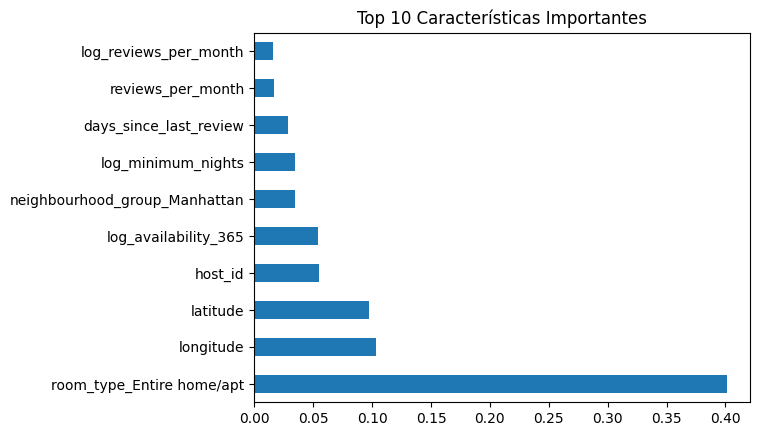

In [44]:
# Obtener la importancia de las características
feature_importances = pd.Series(rf_regressor.feature_importances_, index=X_train.columns)

# Graficar las 10 características más importantes
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Características Importantes')
plt.show()

In [45]:
# Espacio de hiperparámetros a explorar
param_distributions = {
    'n_estimators': np.arange(100, 401, 100),  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt']
}

# Configuración de la búsqueda aleatoria, con menos iteraciones
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=10,  # Reducir el número de iteraciones para aligerar la carga
    cv=3,
    scoring='r2', 
    n_jobs=-1, 
    random_state=42
)

# Ejecutar la búsqueda
random_search_rf.fit(X_train, y_train)

# Mostrar los mejores parámetros y el mejor score encontrado
print("Mejores hiperparámetros:", random_search_rf.best_params_)
print("Mejor R2:", random_search_rf.best_score_)

Mejores hiperparámetros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Mejor R2: 0.6136174891939601


In [46]:
# Usando el mejor modelo encontrado por RandomizedSearchCV
best_rf = random_search_rf.best_estimator_

# Calculando RMSE mediante validación cruzada
scores = cross_val_score(best_rf, X, y, cv=5, scoring='r2')

# Convertir scores a positivo y calcular promedio
r2_scores = scores
print("RMSE promedio de la validación cruzada:", r2_scores.mean())

RMSE promedio de la validación cruzada: 0.5970139296001393


A pesar de que los resultados no son muy buenos, hemos de tener en cuenta la naturaleza de los datos y que el objetivo del ejercicio no es tanto entrenar un modelo como estudiar el EDA y el tratamiento de los datos previamente al entrenamiento del modelo. 
Consideramos que el planteamiento del problema es adecuado, intentando extraer toda la información útil posible del df. Para mejorar los resultados de los modelos podríamos estudiar, entre otras cosas:
+Eliminar información duplicada en los OneHotEncoding de las poblaciones y de las columnas de cadenas de palabras frecuentes (como puede ser 'Brooklyn' por un lado y 'Brooklyn apartment' en el otro)
+ Realizar una reducción de las variables aplicando Lasso
+ Estudiar en mayor profundidad la variable 'host_id', ya que a pesar de aparecer como de las más influyentes, hay dudas sobre cómo puede estar afectando a la predicción de los modelos. 
+ Estudiar por qué el mejor RF con RandomSearch tiene un rendimiento menor que el anterior modelo RF (ampliando las estadísticas de cada uno, para empezar)

#### NOTA
Se ha omitido el guardado de los datos procesados puesto que tenían un tamaño excesivo.